In [6]:
import os
import pandas as pd

# Falls die Datei im aktuellen Verzeichnis oder in einem "data"-Unterordner liegt
file_path_current = "song_lyrics.csv"
file_path_data = os.path.join("data", "song_lyrics.csv")

if os.path.exists(file_path_current):
    file_path = file_path_current
elif os.path.exists(file_path_data):
    file_path = file_path_data
else:
    # Backup mit absolutem Pfad
    file_path = "/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/song_lyrics.csv"

print("Using file path:", file_path)
print("File exists:", os.path.exists(file_path))

try:
    df = pd.read_csv(file_path)
    print(df.head(10))
    print(df.info())
except FileNotFoundError as e:
    print(f"Error: {e}")

Using file path: /Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/song_lyrics.csv
File exists: True
               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4   

In [7]:
print(df["tag"].unique())

['rap' 'rb' 'rock' 'pop' 'misc' 'country']


However, this df has a few problems that need to be addressed before using it for this project. Firstly, this df has lyrics from all different languages. For the purpose of this project, I'm going to limit the scope to just English songs. There may be a deeper correlation that can be made by using all languages, but for readability I chose to limit it to English. This can be easily done by filtering out songs using the `language` column restricting it to only 'en'.

Some of the data entries lack a tag or lack substantial lyrics which would break or confuse the AI so those will also be removed from the database.

Additionally, the lyrics of a song on Genius are split up by verses and choruses and other musical notations separated from the lyrics with brackets. For example, a song can have the line `[Verse 1: Drake]`that follows before a verse sung by Drake. For the purposes of this project, those lines will remain in the lyrics. They aren't technically lyrics, but the AI can notice patterns with artists and verse/chorus/introduction setups to help classify which genre the song is in.

Finally, Genius allows users to upload lyrics for things that aren't songs as well such as scripts or poems. These are all tagged as 'misc,' but some songs are also tagged as misc. For the sake of simplicity, I will be culling all lyrics tagged as misc from the database even if they are songs, leaving just `rap`, `rb`, `rock`, `pop`, and `country` as the possible genre predictions.

In [8]:
db = (
    df
    .loc[df["language"] == "en"]
    .loc[df["tag"] != "misc"]
    .loc[df["tag"] != ""]
    .loc[df["tag"] != None]
    .loc[df["lyrics"] != None]
    .loc[df["lyrics"] != ""]
    .loc[df["lyrics"] != "[Instrumental]"] #some songs without lyrics will squeeze
                                                       #their way onto the website for no
                                                       # discernable reason
)
db = db.sort_values(by="id")

This df has several columns that can be used for all sorts of implementation. For the sake of this project only the `lyrics`, `tag`, and `id` columns are of interest to the AI, and `title` and `artist` help *us* read and understand the data.

`id` is how we iterate through each song, and `title` and `artist` is how we display the name of the song found by the id.

`lyrics` is our text input and `tag` is our classification output. We need these to train the AI.

The `language` column is extraneous now that we have filtered out any songs that are not in english.

In [9]:
columns_of_interest = ['id', 'title','artist', 'lyrics', 'tag']
db = db[columns_of_interest]
db.sort_values(by="id")
db.head()

,id,title,artist,lyrics,tag
0,1,Killa Cam,Cam'ron,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",rap
1,3,Can I Live,JAY-Z,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",rap
2,4,Forgive Me Father,Fabolous,Maybe cause I'm eatin\nAnd these bastards fien...,rap
3,5,Down and Out,Cam'ron,[Produced by Kanye West and Brian Miller]\n\n[...,rap
4,6,Fly In,Lil Wayne,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",rap


Once we've culled all unnecessary data and extraneous columns from the database we are left with a cleaned up set of data to feed to the AI model. However, there are still foreign symbols and other quirks present in the data that will confuse the AI.

Most notably, each of the string values has many many `\n`s signifying new lines in the lyrics page. We want to keep these new-line symbols for the AI to learn from, but they are not separated by spaces and the AI will consider anything not separated by spaces as one word. Consider this song for example:

In [10]:
print(db.loc[db["id"] == 154314].values)

[[154314 'Do I Wanna Know?' 'Arctic Monkeys'
  "[Verse 1]\nHave you got colour in your cheeks?\nDo you ever get that fear that you can't shift the type\nThat sticks around like summat in your teeth?\nAre there some aces up your sleeve?\nHave you no idea that you're in deep?\nI've dreamt about you nearly every night this week\nHow many secrets can you keep?\n'Cause there's this tune I found\nThat makes me think of you somehow an' I play it on repeat\nUntil I fall asleep, spillin' drinks on my settee\n\n[Pre-Chorus]\n(Do I wanna know?) If this feelin' flows both ways?\n(Sad to see you go) Was sorta hopin' that you'd stay\n(Baby, we both know) That the nights were mainly made\nFor sayin' things that you can't say tomorrow day\n\n[Chorus]\nCrawlin' back to you\nEver thought of callin' when\nYou've had a few?\n'Cause I always do\nMaybe I'm too\nBusy bein' yours\nTo fall for somebody new\nNow, I've thought it through\nCrawlin' back to you\n[Verse 2]\nSo have you got the guts?\nBeen wonderin'

In this example you can see there are many pieces of the string that are *supposed* to be separate lines, but because of the special character \n being present and not being buffered by spaces words like "`settee\n\n[Pre-Chorus]\n(Do`" are made. This will completely butcher a one-hot matrix and confuse our AI. To fix this, we can separate `\n` by whitespaces to separate it from the rest of the words.

By just doing this we would separate our word example into "`settee \n \n [Pre-Chorus] \n (Do`." This still leaves words like "`(Do`" and "`[Verse`" present in our example. To solve this, boundary symbols like parentheses and brackets need to be separated by spaces too. By implementing this fix we can keep the musical notation and line separation for the AI to learn from without breaking the AI completely.

To do this adjustement we will be using a regular expression library `re`. Here is what our lyrics will look like after we split these character up with whitespace:

In [11]:
import re
lyrics = db.loc[db["id"] == 154314].values[0][3]

parts = re.split(r"([\n\[\]\(\)])", lyrics)
#print(repr(parts))

whitespace_lyrics = " ".join(filter(None, parts))
print(repr(whitespace_lyrics))

"[ Verse 1 ] \n Have you got colour in your cheeks? \n Do you ever get that fear that you can't shift the type \n That sticks around like summat in your teeth? \n Are there some aces up your sleeve? \n Have you no idea that you're in deep? \n I've dreamt about you nearly every night this week \n How many secrets can you keep? \n 'Cause there's this tune I found \n That makes me think of you somehow an' I play it on repeat \n Until I fall asleep, spillin' drinks on my settee \n \n [ Pre-Chorus ] \n ( Do I wanna know? )  If this feelin' flows both ways? \n ( Sad to see you go )  Was sorta hopin' that you'd stay \n ( Baby, we both know )  That the nights were mainly made \n For sayin' things that you can't say tomorrow day \n \n [ Chorus ] \n Crawlin' back to you \n Ever thought of callin' when \n You've had a few? \n 'Cause I always do \n Maybe I'm too \n Busy bein' yours \n To fall for somebody new \n Now, I've thought it through \n Crawlin' back to you \n [ Verse 2 ] \n So have you got

Much better! Now you can see our original problem "word" of "`settee\n\n[Pre-Chorus]\n(Do`" has been properly split into "`sette \n \n [ Pre-Chorus ] ( Do`". Our data still is not perfect, as you can see there are puncuation symbols like `?` and `,`  and any punctuated word will be considered a separate entry by the AI. So `Know` and `Know?` and `Know,` are all considered unique words. This can be solved by removing the punctuation from our lyrics using `re`.

In [12]:
unpunctuated = re.sub(r"([?.,!:;])",'',whitespace_lyrics)
print(repr(unpunctuated))

"[ Verse 1 ] \n Have you got colour in your cheeks \n Do you ever get that fear that you can't shift the type \n That sticks around like summat in your teeth \n Are there some aces up your sleeve \n Have you no idea that you're in deep \n I've dreamt about you nearly every night this week \n How many secrets can you keep \n 'Cause there's this tune I found \n That makes me think of you somehow an' I play it on repeat \n Until I fall asleep spillin' drinks on my settee \n \n [ Pre-Chorus ] \n ( Do I wanna know )  If this feelin' flows both ways \n ( Sad to see you go )  Was sorta hopin' that you'd stay \n ( Baby we both know )  That the nights were mainly made \n For sayin' things that you can't say tomorrow day \n \n [ Chorus ] \n Crawlin' back to you \n Ever thought of callin' when \n You've had a few \n 'Cause I always do \n Maybe I'm too \n Busy bein' yours \n To fall for somebody new \n Now I've thought it through \n Crawlin' back to you \n [ Verse 2 ] \n So have you got the guts \

Finally, to get our data the most AI friendly we should fix slang, and regulate capital letters. This gives our AI the highest chance of success and also allows us to more accurately analyze our df.

Some slang we can't fix or predict, but words that end in an apostrophe can be replaced with a 'g', like `Crawlin'` to `Crawling` in our example above. Additionally, `'Cause` can be changed to `Because`. That should affect a significant amount of songs, but it will be impossible to account for all slang. This is good enough for our purposes.

To remove capital letters we can just use python's built in `.lower()` method. Very simple.

In [13]:
final_lyrics = re.sub(r"in'(?= \w|\.|,|$)","ing",unpunctuated.lower())

print(repr(final_lyrics))

"[ verse 1 ] \n have you got colour in your cheeks \n do you ever get that fear that you can't shift the type \n that sticks around like summat in your teeth \n are there some aces up your sleeve \n have you no idea that you're in deep \n i've dreamt about you nearly every night this week \n how many secrets can you keep \n 'cause there's this tune i found \n that makes me think of you somehow an' i play it on repeat \n until i fall asleep spilling drinks on my settee \n \n [ pre-chorus ] \n ( do i wanna know )  if this feeling flows both ways \n ( sad to see you go )  was sorta hoping that you'd stay \n ( baby we both know )  that the nights were mainly made \n for saying things that you can't say tomorrow day \n \n [ chorus ] \n crawling back to you \n ever thought of calling when \n you've had a few \n 'cause i always do \n maybe i'm too \n busy being yours \n to fall for somebody new \n now i've thought it through \n crawling back to you \n [ verse 2 ] \n so have you got the guts \

Now that our data is ready to be cleaned up and AI ready, let's see some analytical metrics to help us wrap our head around what our AI is working with. Our database is currently quite large clocking in at over 3 million songs after misc and empty entries were removed, so for exploratory analysis we will be cutting our database down to 5% of its original size and applying our edits to that subset.

In [14]:
def fix_lyrics(lyrics):
    parts = re.split(r"([\n\[\]\(\)])", lyrics)
    output = " ".join(filter(None, parts))
    output = re.sub(r"([?.,!:;])",'',output)
    output = re.sub(r"in'(?= \w|\.|,|$)","ing",output.lower())
    return output

print(f"original database:{len(db)} songs")
subset = db.sample(frac=0.05)
print(f"subset:{len(subset)} songs")

subset["lyrics"] = subset["lyrics"].apply(fix_lyrics)
subset = subset.sort_values(by="id")
subset.head(20)

original database:3233212 songs
subset:161661 songs


,id,title,artist,lyrics,tag
4,6,Fly In,Lil Wayne,"[ intro ] \n so they ask me \n ""young boy \n w...",rap
32,26,A Milli,Fabolous,it's time to get money \n i got a million reas...,rap
38,32,Suck My Dick,Lil' Kim,[ intro the notorious big ] \n love me when i'...,rap
47,39,Fireman,Lil Wayne,[ intro ] \n ( weezy baby ) \n shh the fireman...,rap
66,58,A Star Is Born,JAY-Z,[ hook the world famous tony williams + jay-z ...,rap
95,86,All Falls Down,Kanye West,[ chorus syleena johnson & kanye west ] \n oh ...,rap
112,103,Tha Crossroads D.J. U-Neeks Mo Thug Remix,Bone Thugs-N-Harmony,[ intro bone thugs-n-harmony ] \n bone bone bo...,rap
126,131,Day ‘N’ Nite Nightmare,Kid Cudi,[ intro ] \n uh uh uh uh \n uh uh \n \n [ vers...,rap
171,169,Roc Boys And the Winner Is...,JAY-Z,[ produced by lv sean c and diddy ] \n \n [ in...,rap
176,177,2009 BET Hip Hop Awards - Cypher 3,BET,[ intro mos def ] \n peace welcome to this cyp...,rap


Taking 5% of our database leaves us with 646,000 songs which is still a substantial amount of data. Now that we have a smaller df, let's take a look at some metrics. The metrics of our subset should theorhetically be similar to metrics of our entire df since this is a selection of random songs from the larger df.

Firstly, let's see a plot of how many words appear in our df to get an idea of how long our inputs to the AI are going to be. We can show this with a histogram.

<Axes: >

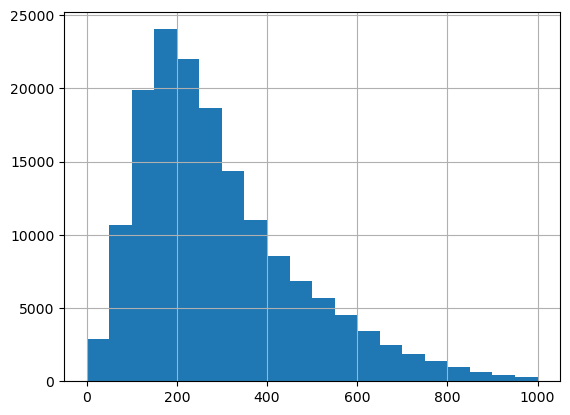

In [15]:
subset['lyrics'].str.split().map(lambda x: len(x)).hist(range=[0, 1000],bins=20)

Let's see how many words total our vocabulary will likely have. This is going to be a generous estimation using a subset just because of how unique each entry is, but it's still a valuable estimate. Common words and stop-words will make up the brunt of our vocabulary but there will be a lot of strange outliers that come from mispellings or intentionally incorrect spellings of words.

In [16]:
from collections import Counter
total = len(Counter(" ".join(subset["lyrics"]).split()))
print(total)

342449


This vocabulary is quite large and the majority of it is typos, misspellings, and other strangely spelled words that only show up once in a song and never again. My personal favorite skimming through my version of the subset was "coo-coo-cachoo." I really have to know what song that was a lyric in because that's mental.

Next, let's see the most common words that appear in our data. Likely the top word is going to be "`\n`" as it is the 'word' that separates lines in the lyrics, so we will be excluding these in our search. Symbols like brackets and parentheses are also likely to be common with the way we split it up in the previous cells, so we will also be ignoring those. Stop words are also bound to be extremely common, so we will be defining a list of common stop words to ignore. Finally we don't want to see instances of musical notations like `verse` and `chorus` if we want to get an accurate idea of the words our AI will be paying attention to.

In [17]:
import nltk

stopwords = nltk.corpus.stopwords.words('english')
stopwords += (['[', ']', '(', ')', '`', 'verse', 'chorus', 'intro', 'outro','like','i\'m','dat','da'])

words = subset['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

words.head(20)

4      ask "young boy gon' second time around gon' co...
32     time get money got million reasons better mill...
38     notorious big love broke filthy fucking rich 1...
47     weezy baby shh fireman comin' yeah yeah yeah y...
66     hook world famous tony williams + jay-z every ...
95     syleena johnson & kanye west oh falls yeah rea...
112    bone thugs-n-harmony bone bone bone bone bone ...
126    uh uh uh uh uh uh 1 day night toss turn keep s...
171    produced lv sean c diddy jay-z winner hov man ...
176    mos def peace welcome cypher black dante black...
181    produced mark 45 king take bass line uh-huh ji...
219    midwest forgot fourth coast ain't nothing thou...
225    "this labor" {*echoes*} {*sample cut scratched...
242    marvin gaye sample really trying baby trying h...
243    produced dr dre & mike elizondo go go go go go...
251    dr dre yeah dr dre party's going thank god fri...
255    2x mystikal pharrell keep bumping wall yeah kn...
257    produced dj toomp stadiu

,Frequency
Word,
know,271255
got,222640
get,198695
yeah,196818
love,195797
go,154414
time,138825
see,138529
oh,137345


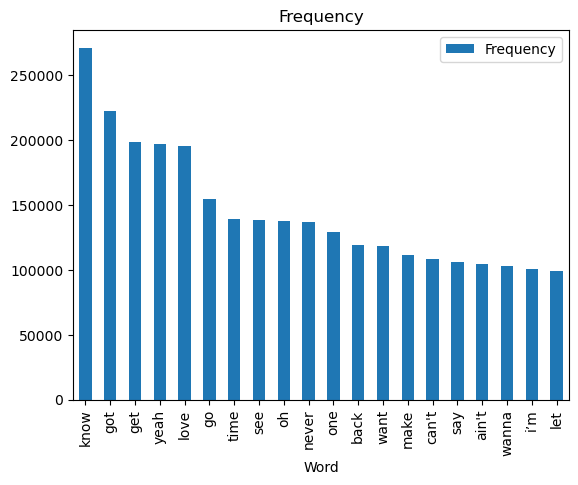

In [18]:
top_words = pd.DataFrame(Counter(" ".join(words).split()).most_common(20),columns=['Word', 'Frequency']).set_index('Word')

top_words.plot(kind='bar', subplots=True)
top_words.head(20)

It's interesting to see how high love is at the top of the list of words. A lot of songs are about love, whether it be for a person or any other thing worth being passionate about. Action words like "go" and "get" and "got" are also very high on the list which makes sense especially since a lot of rap songs are about wealth and possession. I'm also surprised to see that the stop word "I'm" was so common that it even made a re-appearance with the incorrect symbol as the apostrophe. If there was any doubt these are community submitted lyrics, it's certainly been squashed.